In [1]:
import IPython.display
IPython.display.HTML("<style>.container { width:100% !important; margin: 0 auto; }</style>")

In [2]:
%load_ext autoreload
%autoreload 2

In [166]:
import annoy
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
from boiler.vqvae import VQVAE
from boiler.mel import Audio2Mel
from boiler.dataset import WavFile

In [5]:
!ls -lahctr exp/c | tail -2

-rw-rw-r-- 1 proger proger 2.8M Nov 20 00:34 vqvae_024.pt
-rw-rw-r-- 1 proger proger  43M Nov 20 00:35 events.out.tfevents.1605824658.rt.1437421.0


In [6]:
model = VQVAE(in_channel=1).to('cuda')
model.load_state_dict(torch.load('exp/c/vqvae_024.pt'))

<All keys matched successfully>

In [37]:
fft = Audio2Mel(n_mel_channels=80).cuda()

In [22]:
data_path = Path('/home/proger/coub-crawler/monthlyLog/wav')
wavs = {wav.stem: WavFile(wav) for wav in data_path.glob('*.wav')}

In [148]:
index = annoy.AnnoyIndex(vec.numel(), 'euclidean')
wavi = {}

In [149]:
for i, (k, wav) in enumerate(wavs.items()):
    wavi[i] = k
    ids = model.encode(fft(wav[0].unsqueeze(0).cuda()).unsqueeze(0))[2]
    vec = F.normalize(torch.bincount(ids.view(-1), minlength=512).float(), dim=0, p=2)
    index.add_item(i, vec)

In [150]:
index.build(100)

True

In [138]:
wavs.keys()

dict_keys(['2e1bkm', 'rk5ya', 'ddyvv', '26vzgc', 'd3ssh', '1ixjzd', '1xlsgf', '26bhxr', 'dtoqb', '1x1al9', 'ai046', 'bucoi', 'et9ut', '2fcx8k', 'rv4el', '1ojp17', '2ky1j8', 'co0qx', '1hcos0', '21h9if', '1tfi56', 's9o9j', '2basqd', '23md0y', '2c1cxq', '2baven', '1jowpn', '2dsvve', '2la6by', 'us99u', '2h1emk', 'wywrp', '27le44', 'yqxs1', '1r783x', '1o7744', '11jt32', '1mx7rp', '2hlgi3', '11gojy', '14oea5', '1m7v5u', 'uj16d', '22qmed', '14l24l', '2bl9hd', '217xlh', '1c04zb', 'w72pm', 'c2x7i', '1hgc8e', 'g9ukv', '1onxup', '268nwf', 'eq1v8', '11n8zr', '1go7dx', '2hr5cq', 'hjntk', '1ntuh8', 'ywgfs', '1o7oce', 'w7oae', '2b5o1z', '2644go', '1riheb', '2au5ru', '19ren3', '3543s', '2anqz7', '1nv88w', '2jjhbn', '1eblu9', 'ccg1o', '2j3mlb', '1jvm5r', 'veiyj', 'y8zjc', 'cz3uk', '1i8e3r', '1azuq0o0', '1d85dg', 'feou2', '1drtys', 'fje3v', '1k1kg4', '1mqiv8', '2fgpe0', 'iusgu', 'ciw4g', '12luh6', 'zf2nf', '2eh2a0', '2bv2h5', '20njbq', '14rydo', '1gmh52', 'tv5k9', '2jbxaw', 'ydz4d', 'hi8bt', '1rxwtn', '

In [161]:
index.get_nns_by_item(3253, 10)

[3253, 9314, 4012, 9056, 2778, 8922, 5850, 2466, 1191, 4853]

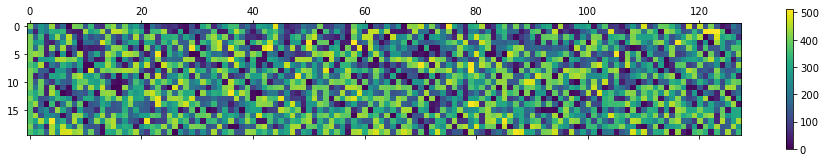

In [216]:
plt.matshow(ids.detach().cpu().squeeze())
plt.colorbar()

query wmkpv


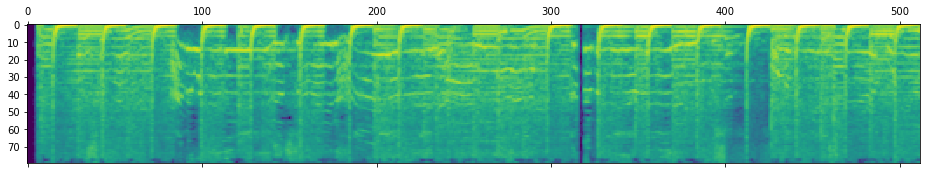

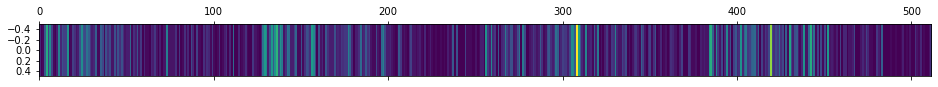

# result 4813 x6pab 0.48079195618629456


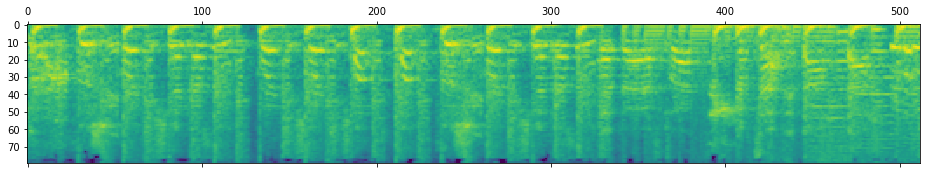

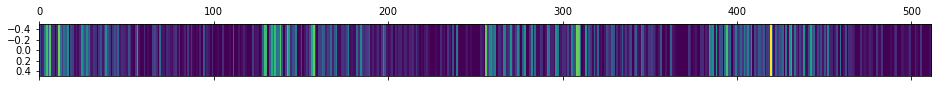

# result 5796 u94cs 0.48262354731559753


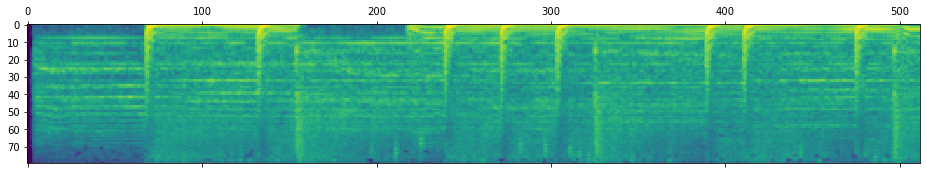

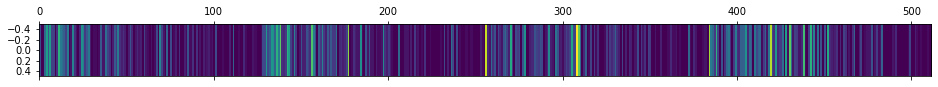

# result 2199 28o8ux 0.4850015938282013


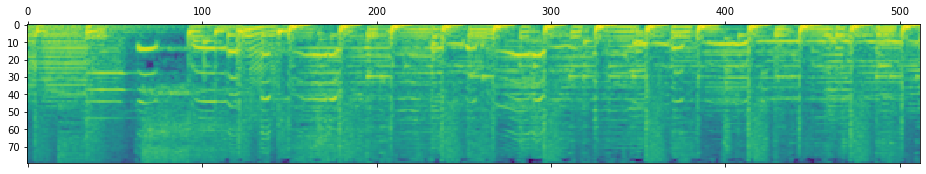

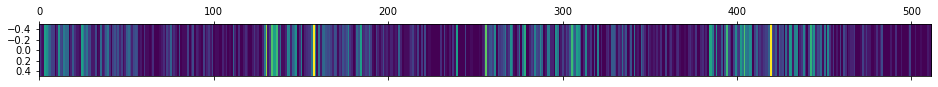

# result 8726 sbq7m 0.48546943068504333


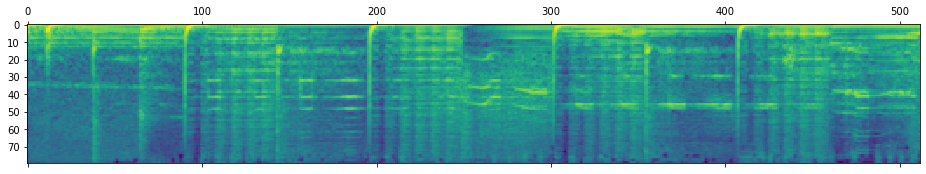

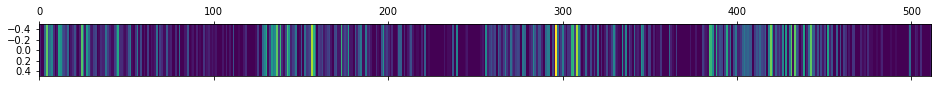

# result 1157 10684s 0.4855045974254608


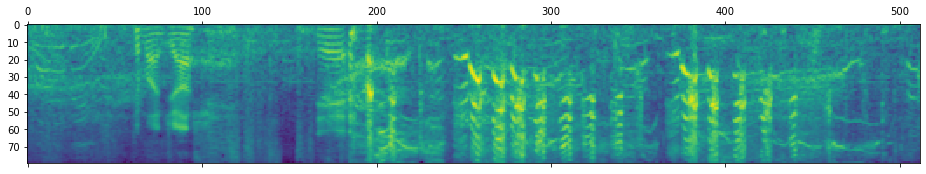

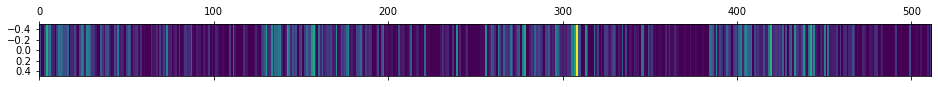

# result 8818 dbtay 0.49021920561790466


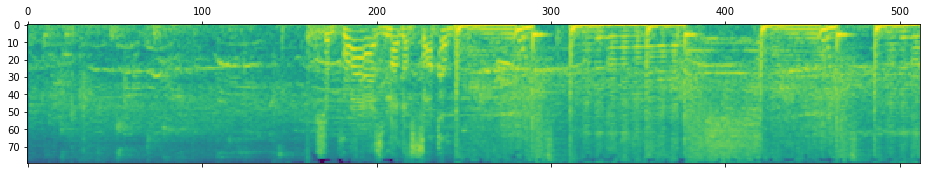

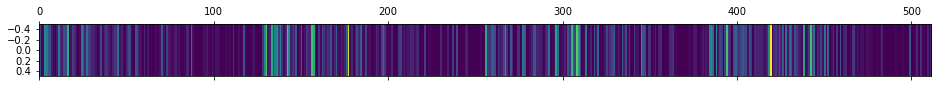

# result 4939 41u3qu24 0.4938203990459442


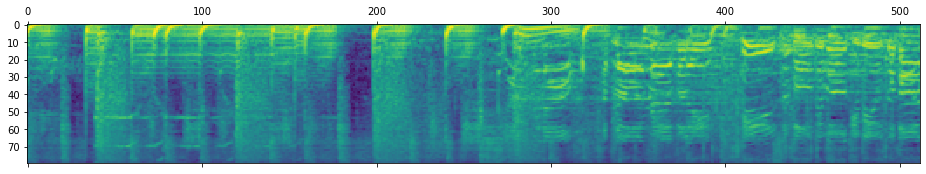

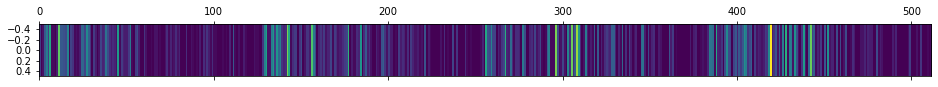

# result 2530 2duphq 0.4940807521343231


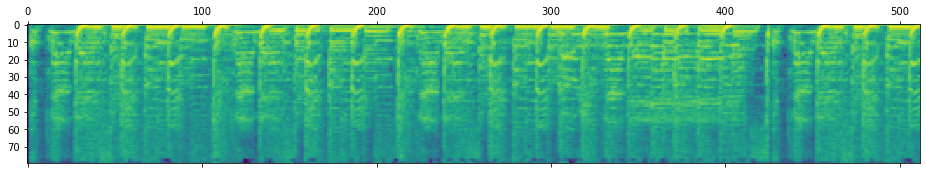

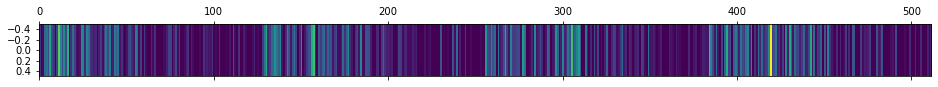

# result 9018 v0kvq 0.49464014172554016


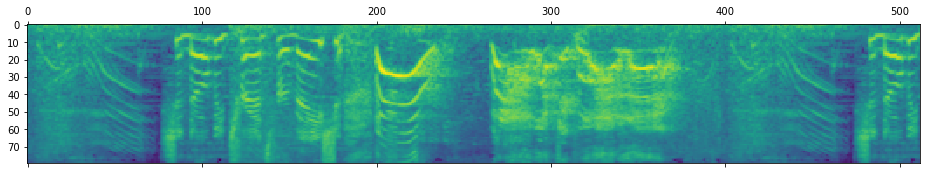

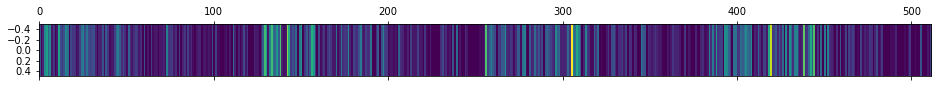

# result 1638 1x7m4t 0.4960562586784363


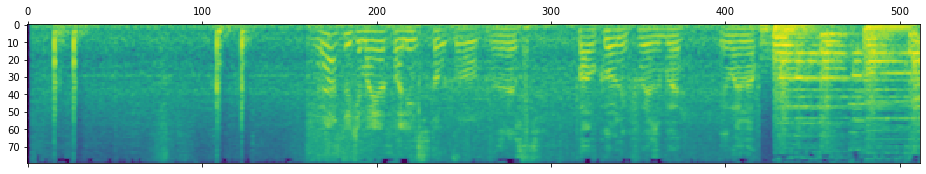

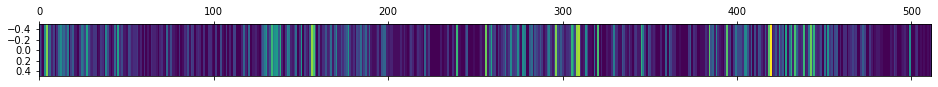

In [202]:
query_key = 'wmkpv'
query_audio = wavs[query_key][0]
query = fft(query_audio.unsqueeze(0).cuda())
embs, _, ids = model.encode(query.unsqueeze(0))
vec = F.normalize(torch.bincount(ids.view(-1), minlength=512).float(), dim=0, p=2)

print('query', query_key)
plt.matshow(query.detach().cpu().squeeze())
plt.show()
plt.matshow(vec.detach().cpu()[None,:], aspect=30)
plt.show()
IPython.display.display(IPython.display.Audio(query_audio, rate=16000))

for i, dist in zip(*index.get_nns_by_vector(vec, 10, include_distances=True)):
    print('# result', i, wavi[i], dist)
    audio = wavs[wavi[i]][0]
    plt.matshow(fft(audio.unsqueeze(0).cuda()).detach().cpu().squeeze())
    plt.show()
    plt.matshow(torch.tensor(index.get_item_vector(i))[None,:], aspect=30)
    plt.show()
    IPython.display.display(IPython.display.Audio(audio, rate=16000))